To install xgboost package: *!conda install -c conda-forge xgboost*

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [3]:
# Check if we have a GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5759375779438212673, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9274383884996519903
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4784477941398627272
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1105655419220232438
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
source = '/content/drive/My Drive/Colab_Notebooks/TFM_Kschool/traffic_data.zip'
df = pd.read_csv(source,sep=',')

In [0]:
df.head()

,id,intensidad,ocupacion,carga,vmed,periodo_integracion,Date,Lat,Long,M30,URB,N
0,1001,204,12,0,73,5,2018-01-01 00:00:00,40.409729,-3.740786,1,0,1
1,1002,252,1,0,79,5,2018-01-01 00:00:00,40.408029,-3.743760,1,0,1
2,1003,420,2,0,82,5,2018-01-01 00:00:00,40.406824,-3.746834,1,0,1
3,1006,288,1,0,75,5,2018-01-01 00:00:00,40.411894,-3.736324,1,0,1
4,1009,276,0,0,76,5,2018-01-01 00:00:00,40.416233,-3.724909,1,0,1


SPLITTING DATE IN SEPARATED FIELDS

In [7]:
%%time
df['FechaAUX'], df['HoraAUX'] = df['Date'].str.split(' ', 1).str
df['Anio'], df['Mes'], df['Dia'] = df['FechaAUX'].str.split('-', 2).str
df['Hora'], df['Minutos'], df['Segundos']= df['HoraAUX'].str.split(':', 2).str

CPU times: user 29.3 s, sys: 818 ms, total: 30.1 s
Wall time: 30.1 s


In [0]:
df.sample(5)

,id,intensidad,ocupacion,carga,vmed,periodo_integracion,Date,Lat,Long,M30,URB,N,FechaAUX,HoraAUX,Anio,Mes,Dia,Hora,Minutos,Segundos
2137526,3536,593,2,17,80,15,2018-05-20 02:15:00,40.441692,-3.658754,0,1,1,2018-05-20,02:15:00,2018,05,20,02,15,00
2277805,1022,312,3,0,35,5,2018-05-23 08:45:00,40.393636,-3.703247,0,1,1,2018-05-23,08:45:00,2018,05,23,08,45,00
274670,3521,2760,5,53,87,15,2018-01-07 11:15:00,40.492293,-3.670773,1,0,1,2018-01-07,11:15:00,2018,01,07,11,15,00
125959,6799,188,1,11,79,15,2018-01-03 23:15:00,40.454747,-3.745022,1,0,1,2018-01-03,23:15:00,2018,01,03,23,15,00
1746373,6835,1260,10,0,58,5,2018-05-10 21:45:00,40.417314,-3.721794,0,1,1,2018-05-10,21:45:00,2018,05,10,21,45,00


In [0]:
df=df.drop(['FechaAUX','HoraAUX','Date'],axis=1)

Also Drop "Segundos" column due to its value is always 00

In [0]:
df=df.drop(['Segundos'],axis=1)

Casting to int the hour and date columns

In [0]:
df = df.astype({"Anio": int, "Mes": int, "Dia": int, "Hora": int, "Minutos": int})

In [16]:
df.dtypes

id                       int64
intensidad               int64
ocupacion                int64
carga                    int64
vmed                     int64
periodo_integracion      int64
Lat                    float64
Long                   float64
M30                      int64
URB                      int64
N                        int64
Anio                     int64
Mes                      int64
Dia                      int64
Hora                     int64
Minutos                  int64
dtype: object

In [0]:
df.sample(5)

,id,intensidad,ocupacion,carga,vmed,periodo_integracion,Lat,Long,M30,URB,N,Anio,Mes,Dia,Hora,Minutos
393678,6362,0,0,0,0,15,40.433831,-3.655764,0,1,1,2018,1,10,4,45
1301814,3838,1123,26,70,40,15,40.406153,-3.664191,1,0,1,2018,1,31,19,30
2058624,1048,144,1,0,85,5,40.409210,-3.664111,0,1,1,2018,5,18,4,0
1308051,6767,820,3,17,86,15,40.443977,-3.739627,1,0,1,2018,1,31,23,15
316611,6934,1788,8,54,60,15,40.484920,-3.672710,1,0,1,2018,1,8,9,30


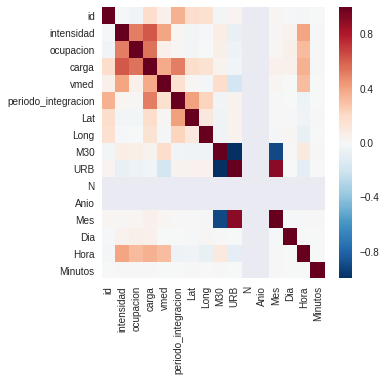

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(5,5))
sns.heatmap(df.corr())

SPLITTING THE DATASET IN TRAIN AND TEST SETS

In [0]:
X=df.drop(['carga'],axis=1)

In [13]:
type(X['Hora'][0])

numpy.int64

In [14]:
X.shape

(2639610, 15)

In [0]:
y=df['carga']

In [16]:
y.shape

(2639610,)

In [0]:
import numpy as np

In [0]:
rg1=KNeighborsRegressor(n_neighbors=5)

In [0]:
%%time
cvs_kn=cross_val_score(rg1,X,y,scoring='neg_mean_squared_error')

CPU times: user 4min 33s, sys: 2.83 s, total: 4min 36s
Wall time: 4min 36s


In [0]:
-cvs_kn.mean()

3.976986372986918

In [0]:
#MSE
(-cvs_kn.mean())**2

1.9942382939325274

With GridSearchCV

%%time
reg_KN=GridSearchCV(KNeighborsRegressor(n_neighbors=1),
                    param_grid={"n_neighbors":range(1,20)},
                    scoring="neg_mean_squared_error",
                    cv=10)

%%time
reg_KN.fit(X,y)

np.sqrt(-reg_KN.best_score_)

reg_KN.best_param_

In [0]:
%%time
#Decission Tree
reg_DeciTree=GridSearchCV(DecisionTreeRegressor(min_samples_leaf=1,max_depth=4),
                          param_grid={"min_samples_leaf":[10,20,30,40,70,100],"max_depth":range(2,5)},
                          scoring="neg_mean_squared_error"
                          )
reg_DeciTree.fit(X,y)
print(reg_DeciTree.best_score_)
print(reg_DeciTree.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


-75.86917325250708
{'max_depth': 4, 'min_samples_leaf': 40}
CPU times: user 3min 21s, sys: 2.3 s, total: 3min 24s
Wall time: 3min 24s


In [0]:
import numpy as np
print(-reg_DeciTree.best_score_)
print(np.sqrt(-reg_DeciTree.best_score_))

75.86917325250708
8.710291226618493


In [0]:
%%time
#Decission Tree
reg_DeciTree2=GridSearchCV(DecisionTreeRegressor(min_samples_leaf=1,max_depth=4),
                          param_grid={"min_samples_leaf":[10,20,30,40,70,100],"max_depth":range(2,10)},
                          scoring="neg_mean_squared_error"
                          )
reg_DeciTree2.fit(X,y)
print(np.sqrt(-reg_DeciTree2.best_score_))
print(reg_DeciTree2.best_params_)

6.296403723326066
{'max_depth': 9, 'min_samples_leaf': 20}
CPU times: user 30min 2s, sys: 1min 20s, total: 31min 22s
Wall time: 31min 50s


In [0]:
%%time
#Random Forest
reg_RF=GridSearchCV(RandomForestRegressor(n_estimators=100,min_samples_leaf=1,max_depth=4),
                          param_grid={"min_samples_leaf":[10,20,30,40,70,100],"max_depth":range(2,5)},
                          scoring="neg_mean_squared_error"
                          )
reg_RF.fit(X,y)
print(-reg_RF.best_score_)
print(np.sqrt(-reg_RF.best_score_))
print(reg_RF.best_params_)

75.17759082790329
8.670501186661777
{'max_depth': 4, 'min_samples_leaf': 20}
CPU times: user 3h 3min 42s, sys: 1min 2s, total: 3h 4min 44s
Wall time: 3h 5min 1s


In [0]:
%%time
#XGBoost
reg_XGB=GridSearchCV(XGBRegressor(n_estimators=100,min_samples_leaf=1,max_depth=4),
                          param_grid={"min_samples_leaf":[10,20,30,40,70,100],"max_depth":range(2,5)},
                          scoring="neg_mean_squared_error"
                          )
reg_XGB.fit(X,y)
print(reg_XGB.best_score_)
print(np.sqrt(-reg_XGB.best_score_))
print(reg_XGB.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


-30.24002805332065
5.499093384669936
{'max_depth': 4, 'min_samples_leaf': 10}
CPU times: user 2h 18min 14s, sys: 6.27 s, total: 2h 18min 20s
Wall time: 2h 18min 18s


In [0]:
%%time
#Random Forest
reg_RF2=GridSearchCV(RandomForestRegressor(n_estimators=100,min_samples_leaf=1,max_depth=4),
                          param_grid={"min_samples_leaf":[10,20,30,40,70,100],"max_depth":range(20,25)},
                          scoring="neg_mean_squared_error"
                          )
reg_RF2.fit(X,y)
print(reg_RF2.best_score_)
print(np.sqrt(-reg_RF2.best_score_))
print(reg_RF2.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


-8.224883580779533
2.867905783107167
{'max_depth': 19, 'min_samples_leaf': 10}
CPU times: user 4h 40min 21s, sys: 11.6 s, total: 4h 40min 33s
Wall time: 4h 40min 36s


In [0]:
%%time
#XGBoost
reg_XGB2=GridSearchCV(XGBRegressor(n_estimators=100,min_samples_leaf=1,max_depth=4),
                          param_grid={"min_samples_leaf":[10,20,30,40,70,100],"max_depth":range(20,25)},
                          scoring="neg_mean_squared_error"
                          )
reg_XGB2.fit(X,y)
print(reg_XGB2.best_score_)
print(np.sqrt(-reg_XGB2.best_score_))
print(reg_XGB2.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [0]:
%%time
#Random Forest
reg_RF3=GridSearchCV(RandomForestRegressor(n_estimators=100,min_samples_leaf=1,max_depth=4),
                          param_grid={"min_samples_leaf":[10,20,30,40,70,100],"max_depth":range(29,30)},
                          scoring="neg_mean_squared_error"
                          )
reg_RF3.fit(X,y)
print(reg_RF3.best_score_)
print(np.sqrt(-reg_RF3.best_score_))
print(reg_RF3.best_params_)

In [0]:
%%time
#XGBoost
reg_XGB3=GridSearchCV(XGBRegressor(n_estimators=100,min_samples_leaf=1,max_depth=4),
                          param_grid={"min_samples_leaf":[10,20,30,40,70,100],"max_depth":range(29,30)},
                          scoring="neg_mean_squared_error"
                          )
reg_XGB3.fit(X,y)
print(reg_XGB3.best_score_)
print(np.sqrt(-reg_XGB3.best_score_))
print(reg_XGB3.best_params_)

**Regression metrics**
- ‘explained_variance’ 
- ‘neg_mean_absolute_error’
- ‘neg_mean_squared_error’
- ‘neg_mean_squared_log_error’
- ‘neg_median_absolute_error’

# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)